# PP3 - B555 ML
© Haici Yang (hy17@iu.edu)

In [539]:
import numpy as np
import pandas as pd
from abc import ABCMeta, abstractmethod
from numpy.linalg import inv
import math
import time
from matplotlib import pyplot as plt

In [10]:
def load_data(data_name):
    x_path = 'pp3data/' + data_name + '.csv'
    t_path = 'pp3data/labels-' + data_name + '.csv'
    X0 = np.asarray(pd.read_csv(x_path, header = None))
    w0 = np.reshape(np.ones(len(X0)), (len(X0),1))
    X = np.hstack((w0,X0))
    t = np.asarray(pd.read_csv(t_path, header = None))

    return X, t

### Implementing the Generalized Linear Model

A abstrct class of "Family" was defined to fit all distribution model. Different models implement the link function, first/second order deviation, prediction etc. in different ways.

In [523]:
class Family(metaclass=ABCMeta):
    # all families
    
    @abstractmethod
    def inv_link(self, a): # definition of inverse of link function - y=f()
        pass
    
    @abstractmethod
    def d_lp(self, t, y): # first derivative term d in log posterior
        pass
    
    @abstractmethod
    def r_lp(self, t, y): # second derivative term r in log posterior
        pass
    
    @abstractmethod
    def predict_value(self, a): # how the model predicted with W_map
        pass
    
    @abstractmethod
    def predict_err(self, t_h, t): # how the model predicted with W_map
        pass
    
    
class Logistic_Family(ExponentialFamily):
    
    def inv_link(self, a): 
        return 1/(1+np.exp(-a))
    
    def d_lp(self, t, y): 
        return t-y
     
    def r_lp(self, t, y):
        return y*(1-y)
    
    def predict_value(self, a):
        return np.array([int(i) for i in a >= 0.5]).reshape((len(a),1))
    
    def predict_err(self, t_h, t):
        return np.array([int(i) for i in t_h != t]).reshape((len(t),1))
    

class Poisson_Family(ExponentialFamily):
    
    def inv_link(self, a): 
        return np.exp(a)
    
    def d_lp(self, t, y): 
        return t-y
     
    def r_lp(self, t, y):
        return y
    
    def predict_value(self, a):
        lamda = np.exp(a)
        return np.floor(lamda)
    
    def predict_err(self, t_h, t):
        return np.abs(t_h - t)

class Ordinary_Family(ExponentialFamily):
    
    def __init__(self,s=1,k=5):
        self.k = k
        self.s = s
        self.phi = [-np.inf, -2, -1, 0, 1, np.inf]        
    
    def inv_link(self, a):
        s = self.s
        phi = self.phi
        
        y = np.zeros((len(a), len(phi)))
        for i in range(len(a)):
            for j in range(len(phi)):
                y[i, j] = 1 / (1 + np.exp(- s * (phi[j] - a[i])))
     
        return y
    
    def d_lp(self, t, y): 

        d = [y[i,t[i]] + y[i,t[i]-1]-1 for i in range(len(t))]
        #print(len(d),d[0].shape)
        #print(d[:10])
        
        return np.reshape(d,(len(d),1))
     
    def r_lp(self, t, y):
        
        s = self.s
        phi = self.phi
        
        r = [y[i, t[i]]*(1 - y[i,t[i]]) + y[i,t[i]-1]*(1 - y[i,t[i]-1]) for i in range(len(t))]
        r = s * s * r
        #print(r[:10])
        return np.reshape(r,(len(r),1))
    
    def predict_value(self, a):
        
        s = self.s
        phi = self.phi
        k = self.k
        
        y = np.zeros((len(a), len(phi)))
        p = np.zeros((len(a), k))
        
        for i in range(len(a)):
            for j in range(len(phi)):
                y[i,j] = 1 / (1 + np.exp(-s * (phi[j] - a[i])))
        
        for i in range(len(a)):
            for j in range(k):
                p[i,j] = y[i,j+1] - y[i,j]
        
        
        return np.argmax(p, axis=1)+1
    
    def predict_err(self, t_h, t):
        t = t.squeeze()
        return np.abs(t_h - t)

In [529]:
class GLM:
    def __init__(self, family, alpha=10):

        self.family = family
        self.alpha = alpha
        self.w = None 

    def fit(self, X, t, max_iter = 100): # calculate w_map
        
        
        N = X.shape[0]
        M = X.shape[1]
        
        self.w = np.zeros((M,1))
        n_iter = 0
        is_converged = False
        family = self.family        
        
        start = time.time()
        while n_iter < max_iter and not is_converged:
            n_iter += 1
            a = X.dot(self.w)
            a = np.reshape(a, (len(a),1))
            y = family.inv_link(a)
            d = family.d_lp(t, y)
            r = family.r_lp(t, y)
            g = X.T.dot(d) - self.alpha * self.w
            H = - X.T.dot(np.diag(r.T[0])).dot(X) - np.diag(np.repeat(self.alpha, M))
            
            w_n = self.w
            self.w = self.w - inv(H).dot(g)
            #self.w = np.reshape(self.w, (len(self.w),1))
            if sum(w_n * w_n)!=0 and math.sqrt(sum((self.w - w_n) * (self.w - w_n))) / math.sqrt(sum(w_n * w_n)) < 0.001:
                is_converged = True
            #print(self.w[:10])
        end = time.time()
        runtime = end-start
        
        return n_iter, runtime
        
    def predict(self, X, t): # 
        
        family = self.family  
        a = X.dot(self.w)
        t_h = family.predict_value(a)
        err = family.predict_err(t_h, t)
        
        return (sum(err)/len(err))
    

### Drawing Learning curves with different datasets and models

In [530]:
logistic_model = GLM(family = Logistic_Family())
poisson_model = GLM(family = Poisson_Family())
ordinary_model = GLM(family = Ordinary_Family())

In [531]:
def learning_curve(data_name, model):
    X, t = load_data(data_name)
    repeat = 30

    iter_l = np.zeros(10)
    runtime_l = np.zeros(10)
    m_l = np.zeros((30,10))
    std_l = np.zeros(10)

    for i in range(repeat): # repeat 30 times

        permu_index = np.random.permutation(X.shape[0])
        test_index = permu_index[0:int(np.floor(len(permu_index)/3))]
        train_index = permu_index[int(np.floor(len(permu_index)/3)):]
        X_tr = X[train_index]
        t_tr = t[train_index] 
        X_te = X[test_index]
        t_te = t[test_index]
        
        j = 0
        size_range = np.arange(0.1,1.1,0.1)
        #size_range = [0.1]
        for size in size_range: # Training size
            n_iter, runtime = model.fit(X_tr[:int(len(X_tr)*size)], t_tr[:int(len(X_tr)*size)])
            err_m = model.predict(X_te, t_te)

            iter_l[j] += n_iter
            runtime_l[j] += runtime
            m_l[i][j] = err_m
            #std_l[j] += err_std
            #print('size'+str(size),err_m, err_std)
            j += 1
#             break
#         break
    #print(std_l[j])
    avg_m = np.sum(m_l, axis = 0)/repeat
    avg_std = np.std(m_l, axis = 0)
    avg_rt = sum(runtime_l)/(repeat*10)
    avg_iter = sum(iter_l)/(repeat*10)
    
    print('runtime: {:.2f}'.format(avg_rt))
    print('iter_times: {:.2f}'.format(avg_iter))
    plt.errorbar(np.arange(0.1,1.1,0.1), avg_m, yerr = avg_std)
    #plt.show()
    #plt.errorbar(np.arange(0.1,1.1,0.1), avg_m)
    plt.title(data_name+'-Learning_Curve')
    plt.show()

In [532]:
logistic_model = GLM(family = Logistic_Family())
poisson_model = GLM(family = Poisson_Family())
ordinary_model = GLM(family = Ordinary_Family())

**Weight varified with iristest**

runtime: 0.00
iter_times: 7.67


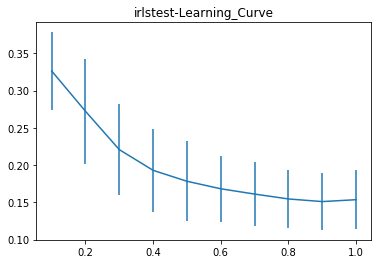

[[-1.84750629]
 [-0.17612462]
 [-0.08197148]
 [-0.08763451]
 [-0.08248397]
 [ 0.00368179]
 [ 0.78625277]
 [ 0.61241295]
 [ 0.81910755]
 [ 0.78847567]
 [ 0.36360345]]


In [535]:
logistic_model = GLM(family = Logistic_Family(), alpha = 0.1)
learning_curve('irlstest', logistic_model)
print(logistic_model.w)

Turns out the predicted weights are fair enough compared with the true weights.

**For dataset A in logistic model**

runtime: 0.01
iter_times: 3.00


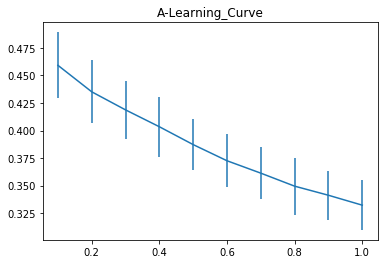

In [506]:
logistic_model = GLM(family = Logistic_Family())
learning_curve('A', logistic_model)

**For dataset usps in logistic model**

runtime: 0.04
iter_times: 6.42


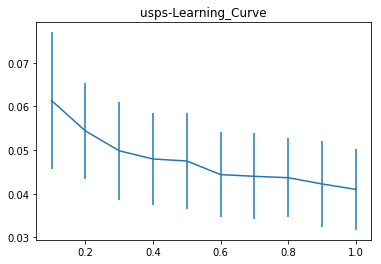

In [461]:
learning_curve('usps', logistic_model)

**For dataset AP in poisson model**

runtime: 0.02
iter_times: 7.47


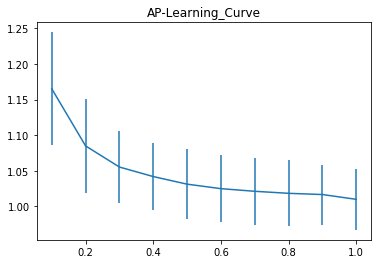

In [462]:
learning_curve('AP', poisson_model)

**For dataset AO in ordinary model**

runtime: 0.15
iter_times: 4.00


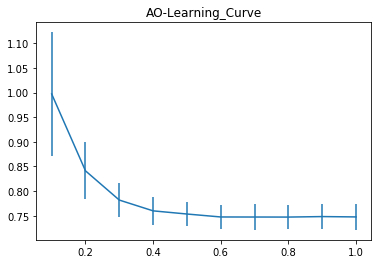

In [533]:
learning_curve('AO', ordinary_model)

 - Learning curves are shown as expected - error getting lower as the size of training data increases. 
 - Runtime on USPS data is longer than those of irls and A data due to the larger number of features USPS has.  
 - Of all the models, ordinary_model with AO dataset has the longest learning time.
 - Learning time is more affected by time per iteration than by number of iterations.

### Model selection by cross validation

I'm using cross validation to do model selection on alpha of every model.

In [478]:
def cross_validation(data_name, model, fold):
    
    #fold = 10 # 10 folds to do cross validation
    X, t = load_data(data_name)

    # Build folds for train set
    start = time.time()
    rindex=np.random.permutation(len(X)) # shuffle and split folds randomly

    f_len = int(len(X)/fold)

    m_l = 0
    
    for k in range(fold):
        test_index = rindex[k * f_len:(k + 1) * f_len]
        train_index = [t for t in rindex if t not in test_index]
        te_x_fold = X[test_index]
        te_t_fold = t[test_index]
        tr_x_fold = X[train_index]
        tr_t_fold = t[train_index]

        n_iter, runtime = model.fit(tr_x_fold, tr_t_fold)
        err_m = model.predict(te_x_fold, te_t_fold)

        m_l += err_m
  
    end = time.time()
    
    return m_l/fold


In [492]:
def model_selection(data_name, m, para_range):
    err_al = []
    
    for value in para_range:
        
        if m == 'logistic':
            model = GLM(family = Logistic_Family(), alpha = value)
        if m == 'poisson':
            model = GLM(family = Poisson_Family(), alpha = value)
        if m == 'ordinary':
            model = GLM(family = Ordinary_Family(), alpha = value)   
            
        fold = 10
        m_l = cross_validation(data_name, model, fold)

        err_al.append(m_l) # Average err of all Cross validation

    para_est = para_range[np.argmin(err_al)]  # Estimated parameter 


    print('dataset:' + data_name)
    print('\tparameter: ', '{:.3f}'.format(para_est))
    
    plt.errorbar(para_range, err_al)
    plt.title(data_name+'-Model Selection')
    plt.show()



dataset:A
	parameter:  0.100


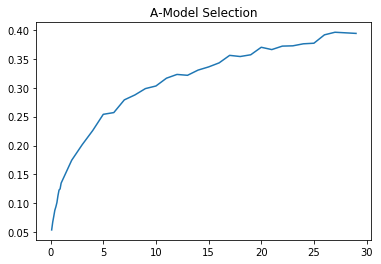

In [488]:
para_range = list(np.arange(0.1, 1.1, 0.1)) +list(range(2,30))
model_selection('A', 'logistic', para_range)

dataset:usps
	parameter:  0.100


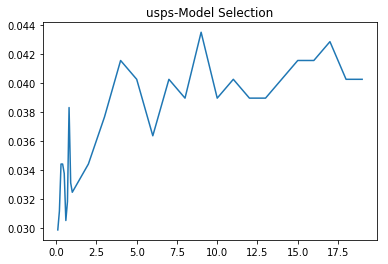

In [481]:
para_range = list(np.arange(0.1, 1.1, 0.1)) +list(range(2,20))
model_selection('usps', 'logistic', para_range)

dataset:AP
	parameter:  85.000


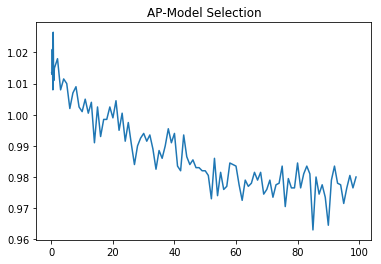

In [536]:
para_range = list(np.arange(0.1, 1.1, 0.1)) +list(range(2,100))
model_selection('AP', 'poisson', para_range)

dataset:AO
	parameter:  22.000


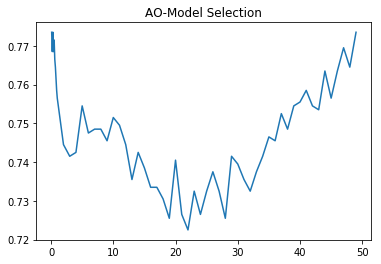

In [538]:
para_range = list(np.arange(0.1, 1.1, 0.1)) +list(range(2,50))
model_selection('AO', 'ordinary', para_range)

The algorithm gives optimized value of alpha for different dataset. 